In [1]:
%matplotlib inline

In [2]:
from IPython.core.pylabtools import figsize
import pandas as pd
import numpy as np
import pymc3 as pm
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import theano.tensor as tt
sns.set_context('notebook')

/home/davi/Envs/machinepy3/machinepy3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
amostra = pd.read_excel('exemplo dados.xlsx')

In [4]:
df = amostra.melt(var_name='amostra').copy()

In [5]:
df.dropna(inplace=True)

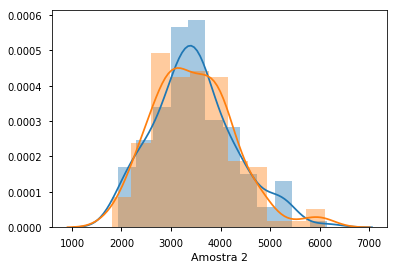

In [6]:
sns.distplot(amostra['Amostra 1'])
sns.distplot(amostra['Amostra 2'].dropna())

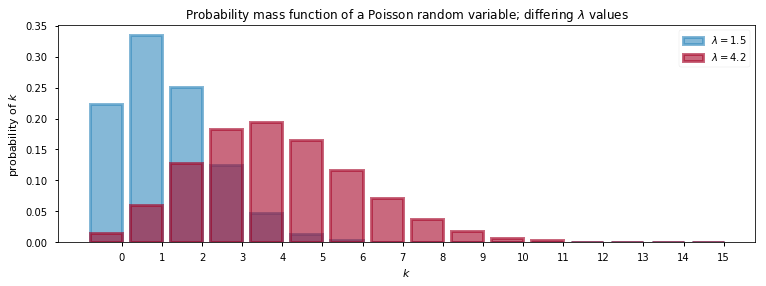

In [7]:
# Poisson Data
figsize(12.5, 4)

a = np.arange(16)
poi = stats.poisson
lambda_ = [1.5, 4.25]
colours = ["#348ABD", "#A60628"]

plt.bar(a, poi.pmf(a, lambda_[0]), color=colours[0],
        label="$\lambda = %.1f$" % lambda_[0], alpha=0.60,
        edgecolor=colours[0], lw="3")

plt.bar(a, poi.pmf(a, lambda_[1]), color=colours[1],
        label="$\lambda = %.1f$" % lambda_[1], alpha=0.60,
        edgecolor=colours[1], lw="3")

plt.xticks(a + 0.4, a)
plt.legend()
plt.ylabel("probability of $k$")
plt.xlabel("$k$")
plt.title("Probability mass function of a Poisson random variable; differing \
$\lambda$ values")

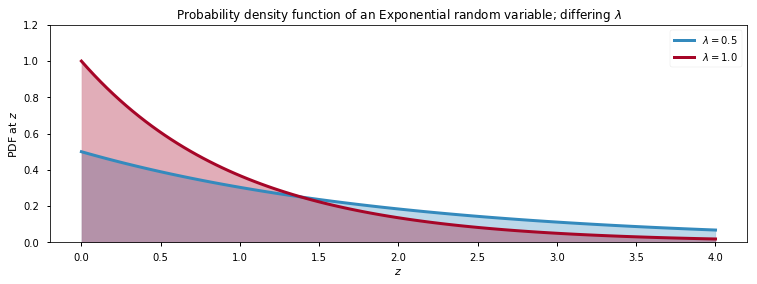

In [8]:
# Exponential Data
a = np.linspace(0, 4, 100)
expo = stats.expon
lambda_ = [0.5, 1]

for l, c in zip(lambda_, colours):
    plt.plot(a, expo.pdf(a, scale=1. / l), lw=3,
             color=c, label="$\lambda = %.1f$" % l)
    plt.fill_between(a, expo.pdf(a, scale=1. / l), color=c, alpha=.33)

plt.legend()
plt.ylabel("PDF at $z$")
plt.xlabel("$z$")
plt.ylim(0, 1.2)
plt.title("Probability density function of an Exponential random variable;\
 differing $\lambda$");

# Evaluating two experimental data... Can we say the experiment is replicating properly?

First let's do some descriptive statistics.

In [9]:
amostra.describe()
# drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
#         109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
#         96,103,124,101,101,100,101,101,104,100,101)
# placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
#            104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
#            101,100,99,101,100,102,99,100,99)

# y1 = np.array(drug)
# y2 = np.array(placebo)
# df = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['drug']*len(drug), ['placebo']*len(placebo)]))


,Amostra 1,Amostra 2
count,151.000000,150.000000
mean,3469.600795,3450.746933
std,826.765346,817.568306
min,1938.820000,1808.480000
25%,2949.720000,2881.195000
50%,3425.940000,3410.685000
75%,3897.610000,3966.265000
max,6150.160000,6116.470000


In [35]:
μ_m = df.value.mean()
μ_s = df.value.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', μ_m, sd=μ_s)
    group2_mean = pm.Normal('group2_mean', μ_m, sd=μ_s)
    

# σ_low = 1.0
# σ_high = df.std().value*2

# with model:
#     group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
#     group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)
# with model:
#     ν= pm.Exponential('ν_minus_one', 1/29.) + 1

# with model:
#     λ1 = group1_std**-2
#     λ2 = group2_std**-2

#     group1 = pm.StudentT('drug', nu=ν, mu=group1_mean, lam=λ1, observed=amostra['Amostra 1'])
#     group2 = pm.StudentT('placebo', nu=ν, mu=group2_mean, lam=λ2, observed=amostra['Amostra 2'])


In [36]:
with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
#     diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
#     effect_size = pm.Deterministic('effect size',
#                                    diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))


In [37]:
with model:
    trace = pm.sample(2000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/davi/Envs/machinepy3/machinepy3/lib/python3.5/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [group2_mean, group1_mean]
100%|██████████| 2500/2500 [00:01<00:00, 2096.81it/s]


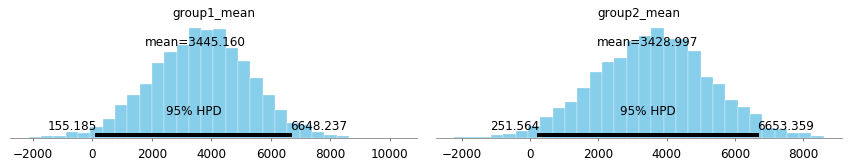

In [39]:
pm.plot_posterior(trace, varnames=['group1_mean','group2_mean'],
                  color='#87ceeb');
# pm.plot_posterior(trace, varnames=['group1_mean','group2_mean', 'group1_std', 'group2_std', 'ν_minus_one'],
#                   color='#87ceeb');

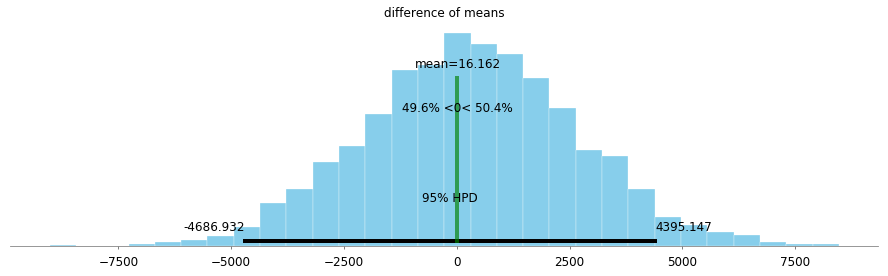

In [41]:
pm.plot_posterior(trace, varnames=['difference of means'],
                  ref_val=0,
                  color='#87ceeb');
# pm.plot_posterior(trace, varnames=['difference of means','difference of stds', 'effect size'],
#                   ref_val=0,
#                   color='#87ceeb');

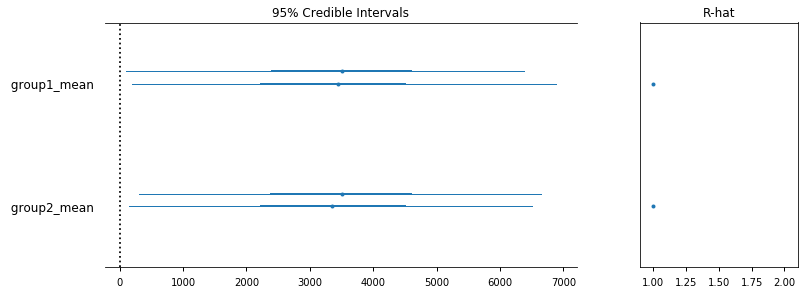

In [42]:
pm.forestplot(trace, varnames=['group1_mean',
                               'group2_mean']);

In [43]:
pm.summary(trace,varnames=['difference of means'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
difference of means,16.162185,2343.120425,31.278444,-4686.932009,4395.146924,4000.0,0.999813
